<a href="https://colab.research.google.com/github/erodola/NumMeth-s2-2022/blob/main/esercizi/ex9/ex9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Benvenuti all'ultima esercitazione del corso. Questa esercitazione ha come argomento JAX, vediamo cosa si tratta! Per prima cosa importiamo le librerie standard viste nelle scorse esercitazioni:

In [2]:
from functools import partial

import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [3]:
!wget https://github.com/erodola/NumMeth-s2-2022/raw/main/esercizi/ex9/u.data
!wget https://github.com/erodola/NumMeth-s2-2022/raw/main/esercizi/ex9/u.item

--2022-05-18 08:16:19--  https://github.com/erodola/NumMeth-s2-2022/raw/main/esercizi/ex9/u.data
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erodola/NumMeth-s2-2022/main/esercizi/ex9/u.data [following]
--2022-05-18 08:16:19--  https://raw.githubusercontent.com/erodola/NumMeth-s2-2022/main/esercizi/ex9/u.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1979173 (1.9M) [text/plain]
Saving to: ‘u.data’

u.data              100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2022-05-18 08:16:19 (33.3 MB/s) - ‘u.data’ saved [1979173/1979173]

--2022-05-18 08:16:19--  https://github.co

Per importare JAX, bisogna eseguire le seguenti righe:

In [5]:
import jax
import jax.numpy as jnp

Come vedete, il modulo jax contiene `numpy` come sottomodulo (che importiamo come `jnp`, similmente a `numpy` che viene importato come `np`). Possiamo già dare una definizione parziale di cosa sia JAX. JAX è una libreria che contiene un ampio sottoinsieme di funzioni di NumPy che possono essere eseguite nativamente sulla GPU. Una GPU, diversamente da una CPU, contiene moltissimi processori paralleli. Per esempio, la GPU Nvidia GeForce 3080 (mobile) contiene ben 6144 cores paralleli.

Come mai vogliamo esseguire le istruzioni di NumPY sulla GPU? Come abbiamo visto nell'ambito di questo corso, l'operazione fondamentale nel calcolo scientifico/numerico è la moltiplicazione tra matrici (e tra tensori qualsiasi in generale). Questa operazione è facilmente paralelizzabile su una una GPU (rimandiamo a un corso sulla programmazione parallela sui dettagli hardware) e quindi eseguire algoritmi numerici su GPU può dare uno speed-up significativo.

Quindi la prima motivazione nell'utilizzo di JAX è la velocità delle operazioni eseguite. Effettuiamo una prova per sincerarci di questo fatto. Creiamo 2 matrici quadrate grandi contenenti tutti 1. La prima volta in NumPy, la seconda volta in JAX, e calcoliamo il tempo di esecuzione della loro moltiplicazione:

In [6]:
%%timeit
n = 5000
X1 = np.ones((n, n))
X2 = np.ones((n, n))

X1 @ X2;

1 loop, best of 5: 6.93 s per loop


Adesso creiamo i tensori con JAX. Per la maggior parte delle funzioni di Numpy, la sintassi è la stessa, come per esempio la creazione di un array contenente tutti 1:

In [7]:
!nvidia-smi

Wed May 18 08:25:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
%%timeit
n = 5000
X1 = jnp.ones((n, n))
X2 = jnp.ones((n, n))

X1 @ X2;

The slowest run took 1296.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.85 ms per loop


Il tempo di esecuzione sembra lo stesso, infatti vengono effettuate 7 run in entrambi i casi ma nel primo caso c'è un loop ogni run, mentre nel secondo caso 100 loop ogni run. Visualizzando i risultati vediamo che abbiamo ottenuto uno speedup di circa ~ **100 volte**!!!

Vediamo il secondo motivo per cui è utile usare JAX: JAX permette di effettuare una serie di trasformazioni su funzioni che contengono operazioni di `jax.numpy`. La più importante tra queste è la trasformazione `jax.grad`: attraverso questa funzione possiamo calcolare i gradienti delle loss in modo *automatico*. Ricordiamo dalla Lezione 8 l'importanza del gradiente nel metodo della discesa del gradiente! Usando JAX dobbiamo progettare solamente la loss, che può avere una forma arbitrariamente complicata, e non dobbiamo più consultare il Matrix Cookbook per calcolare in modo tedioso i gradienti a mano. Ridefiniamo il ciclo di ottimizzazione della discesa del gradiente e vediamo un esempio pratico:

# Problema 1 - Sistema di raccomandazione

In [9]:
import pandas

In [12]:
movies_cols = ['movie_id', 'title']
movies = pandas.read_csv('u.item', sep='|', encoding='latin-1',
                         names=[*movies_cols, *range(24)])
movies = movies[movies_cols]
movies["movie_id"] = movies["movie_id"].apply(lambda x: x-1)

In [13]:
movies

,movie_id,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)
...,...,...
1677,1677,Mat' i syn (1997)
1678,1678,B. Monkey (1998)
1679,1679,Sliding Doors (1998)
1680,1680,You So Crazy (1994)


In [14]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pandas.read_csv('u.data', sep='\t', encoding='latin-1',
                          names=ratings_cols)
ratings = ratings.drop(['timestamp'], axis=1)
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: x-1)
ratings["user_id"] = ratings["user_id"].apply(lambda x: x-1)
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [15]:
ratings

,user_id,movie_id,rating
0,195,241,3.0
1,185,301,3.0
2,21,376,1.0
3,243,50,2.0
4,165,345,1.0
...,...,...,...
99995,879,475,3.0
99996,715,203,5.0
99997,275,1089,1.0
99998,12,224,2.0


In [76]:
users_idx = ratings['user_id'].to_numpy()
movies_idx = ratings['movie_id'].to_numpy()
rating_data = ratings['rating'].to_numpy()

n = max(users_idx) + 1
m = max(movies_idx) + 1

In [75]:
np.sort(users_idx)

array([  0,   0,   0, ..., 942, 942, 942])

In [27]:
print(users_idx)
print(movies_idx)
print(rating_data)
print(f"nr utenti = {n}")
print(f"nr film = {m}")
print(f"nr recensioni = {len(rating_data)}")
print(f"max recensioni = {n*m}")
print(f"nr recensiioni / max recension = {len(rating_data) / (n*m) }")

[195 185  21 ... 275  12  11]
[ 241  301  376 ... 1089  224  202]
[3. 3. 1. ... 1. 2. 3.]
nr utenti = 943
nr film = 1682
nr recensioni = 100000
max recensioni = 1586126
nr recensiioni / max recension = 0.06304669364224531


In [28]:
# matrice di recensioni (sparsa)
A = sparse.coo_matrix((rating_data, (users_idx, movies_idx)), shape=(n,m))

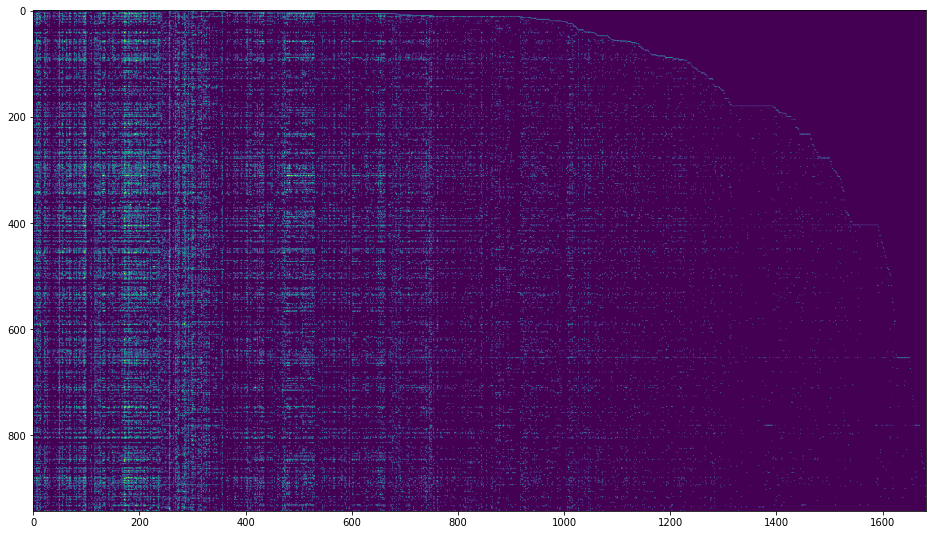

In [23]:
%matplotlib inline
plt.figure(figsize=(16,32))
plt.imshow(A.todense())
# plt.colorbar()

Obiettivo da ottimizzare:
$$ \min_{U,V} \frac{1}{|obs|}\sum_{i,j \in obs} \Vert A_{ij} - U_iV_j^T\Vert^2,$$

$A \in \mathbb{R}^{n \times m}$,
$U \in \mathbb{R}^{n \times d}$,
$V \in \mathbb{R}^{m \times d}$

In [62]:
def loss_recommend(U, V, A):
    return 1/A.data.shape[0]*jnp.linalg.norm(((U[A.row]*V[A.col]).sum(axis=-1)) - A.data)**2

In [63]:
d = 32
U = jnp.array(np.random.randn(n, d))
V = jnp.array(np.random.randn(m, d))

In [64]:
grad_recommend = jax.grad(loss_recommend, argnums=[0,1])

In [66]:
# grad_recommend(U, V, A)

In [67]:
def gradient_descent(grad_fn, loss_fn, alphas, init):
    xs = [init]
    losses = []
    x = init
    for alpha in alphas:
        loss = loss_fn(*x)
        grads = grad_fn(*x)
        x = [x[i] - alpha * grads[i] for i in range(len(grads))]
        xs.append(x)
        losses.append(loss)
    return xs, losses

In [68]:
xs, losses = gradient_descent(grad_fn=partial(grad_recommend, A=A),
                              loss_fn=partial(loss_recommend, A=A),
                              alphas=[20.]*200,
                              init=[U, V])
U_res = xs[-1][0]
V_res = xs[-1][1]

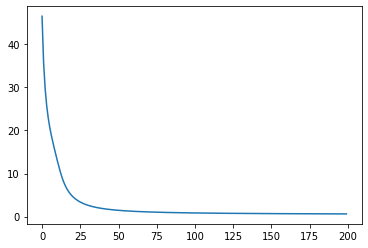

In [69]:
plt.plot(losses)

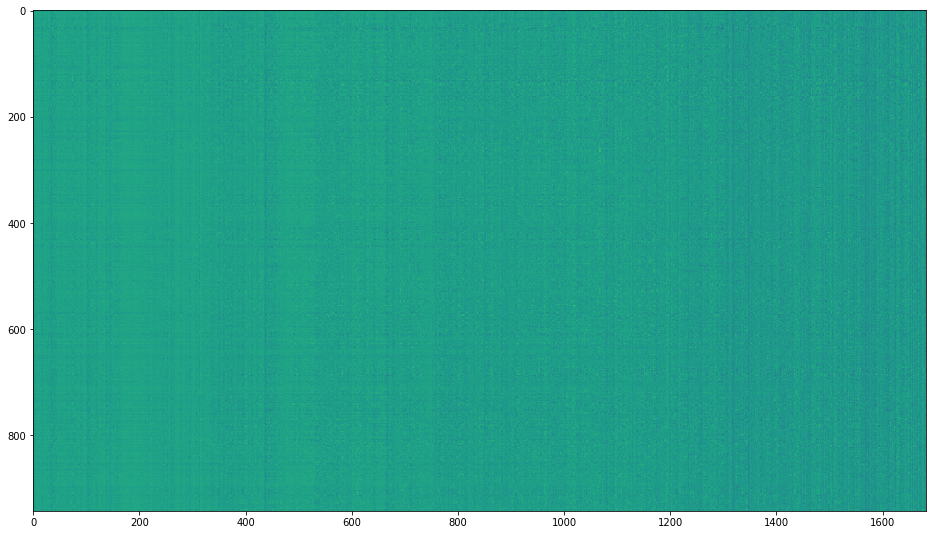

In [71]:
%matplotlib inline
plt.figure(figsize=(16, 32))
plt.imshow(U_res@V_res.T)
# plt.colorbar()

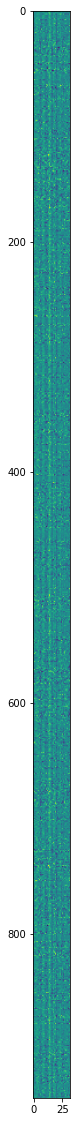

In [73]:
plt.figure(figsize=(10, 20))
plt.imshow(U_res)

# Esercizi

1. Implementare una funzione `compute_measure` che prende in input un embedding query $u$, una sequenza di embeddings $V$ e un booleano `cosine` e calcola la norma $\forall j$ $u^T V_j$ quando `cosine == False` e la cosine similarity $\forall j$ $\frac{u^T V_j}{\Vert u \Vert \Vert V_j \Vert} $ quando `cosine == True`.
3. Trovare i 5 film raccomandati per l'utente `user_id == 0`, escludendo quelli che ha già valutando (e non), usando `cosine = False` e `cosine = True`.
4. Trovare i 5 film più vicini al film `Blade Runner` (`movie_id == 88`) usando `cosibe = False` e `cosine = True`.
5. Regolarizzare la loss usando i seguenti regolarizzatori:
 - Un regolarizzatore di Tikhonov su U e V, dato da $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$. Con questo termine possiamo migliorare il modello, abbassando la norma alta di alcuni outliers (film di nicchia) che possono avere embeddings con una norma molto alta data dall'inizializzazione di $V$.
 - Un prior globale che spinge le predizioni di ogni coppia verso lo zero, chiamato termine di *gravità*. Questo è dato da $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$. Questo termine permette di far imparare correttamente gli embeddings per film che non hanno ricevuto molte recensioni.
6. Ripetere i punti 2. e 3. con la regolarizzazione: comparare i risultati

In [77]:
def compute_measure(u, V, cosine=False):
    if cosine:
        # normalizzare V
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        # normalizzare u
        u = u / np.linalg.norm(u)
    # calcolare il prodotto interno tra u e V
    scores = u @ V.T
    return scores

In [88]:
# definisci una funzione che ti calcola i k nearest neighbour di un query (utente o movies) rispetto agli items (che sono movies)

def get_nn(query, items, movies, k=5, cosine=False, exclude=None):
    # calcola le distanze tra query e items
    distances = compute_measure(query, items, cosine=cosine)
    print(distances)
    # sorta le distanze in ordine crescente e ottieni gli indici permutati, poi trasforma ad una lista
    sorted_args = np.argsort(distances).tolist()
    # se contiene una lista di valori esclusi, metti in results tutti i valori di sorted_args tranne gli esclusi
    if exclude:
        results = [item for item in sorted_args if item not in exclude]
    else:
        # altrimenti
        results = sorted_args
    #if not cosine:
    results = results[-k:]
    #  
    #else:
    #  results = results[:k]
    # filtro di pandas dataframe
    return movies[movies['movie_id'].isin(results)]

In [89]:
# ottieni gli elementi esclusi (ossia quelli che l'utente ha recensito)
excluded = np.where(A.todense()[0, :] > 0.)[1].tolist()
get_nn(U_res[0], V_res, movies, k=5, cosine=False, exclude=excluded)

[ 3.972582   3.860856   3.0889077 ... -1.4472992  0.8714757  1.0193185]


,movie_id,title
429,429,Duck Soup (1933)
468,468,Short Cuts (1993)
1244,1244,Gridlock'd (1997)
1435,1435,Mr. Jones (1993)
1475,1475,Raw Deal (1948)


In [90]:
get_nn(U_res[0], V_res, movies, k=5, cosine=False)

[ 3.972582   3.860856   3.0889077 ... -1.4472992  0.8714757  1.0193185]


,movie_id,title
429,429,Duck Soup (1933)
468,468,Short Cuts (1993)
1244,1244,Gridlock'd (1997)
1435,1435,Mr. Jones (1993)
1475,1475,Raw Deal (1948)


In [91]:
get_nn(U_res[0], V_res, movies, k=5, cosine=True, exclude=excluded)

[ 0.75669736  0.43018103  0.4959917  ... -0.10853699  0.06679173
  0.08500063]


,movie_id,title
273,273,Sabrina (1995)
275,275,Leaving Las Vegas (1995)
317,317,Schindler's List (1993)
482,482,Casablanca (1942)
514,514,"Boot, Das (1981)"


In [92]:
get_nn(U_res[0], V_res, movies, k=5, cosine=True)

[ 0.75669736  0.43018103  0.4959917  ... -0.10853699  0.06679173
  0.08500063]


,movie_id,title
167,167,Monty Python and the Holy Grail (1974)
171,171,"Empire Strikes Back, The (1980)"
184,184,Psycho (1960)
196,196,"Graduate, The (1967)"
482,482,Casablanca (1942)


In [94]:
# 10 tra i migliori valutati dall'utente
results = np.argsort(A.todense()[0, :]).tolist()[0][-15:]
movies[movies['movie_id'].isin(results)]

,movie_id,title
0,0,Toy Story (1995)
80,80,"Hudsucker Proxy, The (1994)"
81,81,Jurassic Park (1993)
86,86,Searching for Bobby Fischer (1993)
171,171,"Empire Strikes Back, The (1980)"
172,172,"Princess Bride, The (1987)"
173,173,Raiders of the Lost Ark (1981)
174,174,Brazil (1985)
175,175,Aliens (1986)
176,176,"Good, The Bad and The Ugly, The (1966)"


In [95]:
# 5 film piu vicini a Blade Runner (cosine = False)
get_nn(V_res[88], V_res, movies, k=5, cosine=False)

[ 4.9006777   3.7659566   3.6334848  ... -0.04550266  1.8109441
  1.3768849 ]


,movie_id,title
486,486,Roman Holiday (1953)
611,611,Lost Horizon (1937)
1072,1072,Shallow Grave (1994)
1435,1435,Mr. Jones (1993)
1540,1540,"Beans of Egypt, Maine, The (1994)"


In [96]:
# 5 film piu vicini a Blade Runner (cosine = True)
get_nn(V_res[88], V_res, movies, k=5, cosine=True)

[ 0.8120105   0.36500525  0.50751513 ... -0.00296831  0.12073372
  0.09987714]


,movie_id,title
11,11,"Usual Suspects, The (1995)"
88,88,Blade Runner (1982)
173,173,Raiders of the Lost Ark (1981)
175,175,Aliens (1986)
182,182,Alien (1979)


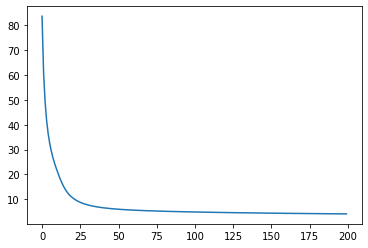

In [97]:
def loss_recommend_reg(U, V, A, lbd_reg = 0.1, lbd_gravity = 1.0):

    # regolarizzatore L2 come visto nella lezione 4
    def tikhonov(U, V):
        return 1/U.shape[0] * jnp.sum(U*U) + 1/V.shape[0] * jnp.sum(V*V)

    # regolarizzatore gravity
    def gravity(U, V):
        return 1/(U.shape[0]*V.shape[0])*jnp.sum((U.T@U) * (V.T@V))

    return (1/A.data.shape[0]*jnp.linalg.norm(((U[A.row]*V[A.col]).sum(axis=-1)) - A.data)**2 +
            lbd_reg * tikhonov(U, V) +
            lbd_gravity * gravity(U, V))

d = 32
U = jnp.array(np.random.randn(n, d))
V = jnp.array(np.random.randn(m, d))
grad_recommend_reg = jax.grad(loss_recommend_reg, argnums=[0, 1])


xs, losses = gradient_descent(grad_fn=partial(grad_recommend_reg, A=A),
                              loss_fn=partial(loss_recommend_reg, A=A),
                              alphas=[20.] * 200,
                              init=[U, V])
U_res = xs[-1][0]
V_res = xs[-1][1]
plt.plot(losses)

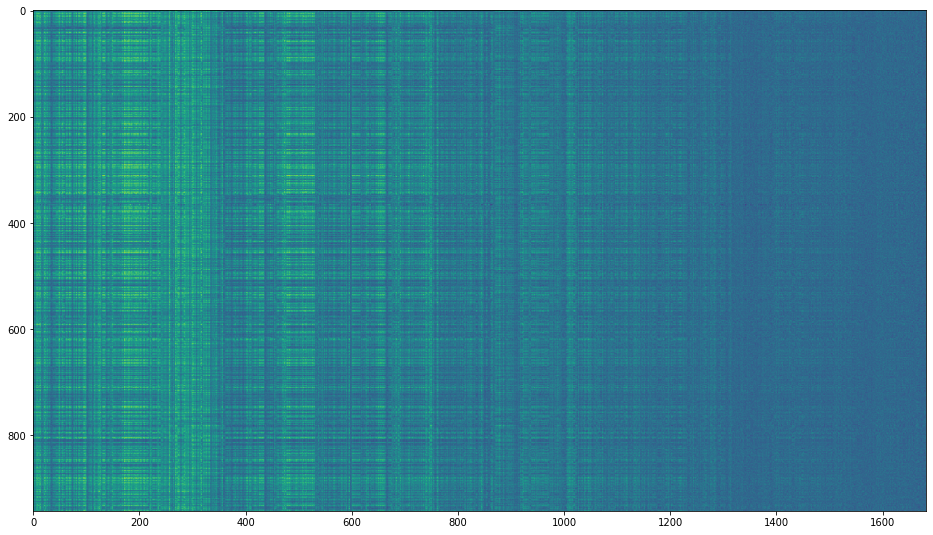

In [98]:
%matplotlib inline
plt.figure(figsize=(16, 32))
plt.imshow(xs[-1][0]@xs[-1][1].T)
# plt.colorbar()

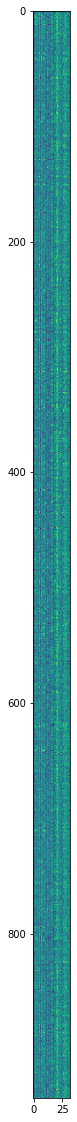

In [99]:
plt.figure(figsize=(10, 20))
plt.imshow(xs[-1][0])

In [100]:
# ottieni gli elementi esclusi (ossia quelli che l'utente ha recensito)
excluded = np.where(A.todense()[0, :] > 0.)[1].tolist()

In [101]:
get_nn(U_res[0], V_res, movies, k=5, cosine=False, exclude=excluded)

[ 4.442541    2.3522563   2.4952793  ...  0.6668019   0.33300078
 -0.45076904]


,movie_id,title
275,275,Leaving Las Vegas (1995)
284,284,Secrets & Lies (1996)
407,407,"Close Shave, A (1995)"
474,474,Trainspotting (1996)
514,514,"Boot, Das (1981)"


In [102]:
get_nn(U_res[0], V_res, movies, k=5, cosine=False)

[ 4.442541    2.3522563   2.4952793  ...  0.6668019   0.33300078
 -0.45076904]


,movie_id,title
49,49,Star Wars (1977)
99,99,Fargo (1996)
126,126,"Godfather, The (1972)"
167,167,Monty Python and the Holy Grail (1974)
171,171,"Empire Strikes Back, The (1980)"


In [103]:
get_nn(U_res[0], V_res, movies, k=5, cosine=True, exclude=excluded)

[ 0.5435226   0.43474224  0.43054867 ...  0.12392728  0.0702251
 -0.07886129]


,movie_id,title
431,431,Fantasia (1940)
651,651,Rosencrantz and Guildenstern Are Dead (1990)
745,745,Real Genius (1985)
958,958,Dazed and Confused (1993)
1011,1011,Private Parts (1997)


In [104]:
get_nn(U_res[0], V_res, movies, k=5, cosine=True)

[ 0.5435226   0.43474224  0.43054867 ...  0.12392728  0.0702251
 -0.07886129]


,movie_id,title
152,152,"Fish Called Wanda, A (1988)"
167,167,Monty Python and the Holy Grail (1974)
174,174,Brazil (1985)
203,203,Back to the Future (1985)
247,247,Grosse Pointe Blank (1997)


In [105]:
# 10 tra i migliori valutati dall'utente
results = np.argsort(A.todense()[0, :]).tolist()[0][-10:]
movies[movies['movie_id'].isin(results)]

,movie_id,title
0,0,Toy Story (1995)
80,80,"Hudsucker Proxy, The (1994)"
81,81,Jurassic Park (1993)
171,171,"Empire Strikes Back, The (1980)"
172,172,"Princess Bride, The (1987)"
173,173,Raiders of the Lost Ark (1981)
174,174,Brazil (1985)
175,175,Aliens (1986)
176,176,"Good, The Bad and The Ugly, The (1966)"
182,182,Alien (1979)


In [106]:
# 5 film piu vicini a Blade Runner (cosine = False)
get_nn(V_res[88], V_res, movies, k=5, cosine=False)

[6.430192   3.412305   1.6892858  ... 0.19247372 1.5437292  2.016918  ]


,movie_id,title
49,49,Star Wars (1977)
63,63,"Shawshank Redemption, The (1994)"
88,88,Blade Runner (1982)
173,173,Raiders of the Lost Ark (1981)
482,482,Casablanca (1942)


In [107]:
# 5 film piu vicini a Blade Runner (cosine = True)
get_nn(V_res[88], V_res, movies, k=5, cosine=True)

[0.4835624  0.387648   0.17916316 ... 0.0219879  0.20010631 0.2168905 ]


,movie_id,title
63,63,"Shawshank Redemption, The (1994)"
88,88,Blade Runner (1982)
153,153,Monty Python's Life of Brian (1979)
175,175,Aliens (1986)
194,194,"Terminator, The (1984)"


# Problema 2 - Ottimizazzione degli iperparametri

In [108]:
sigma_squared_x = 2.
sigma_squared_y = 3.

x = sigma_squared_x*np.random.randn(30)
a_gt = 3.
b_gt = 2.
y_gt = x*a_gt + b_gt
z_y = sigma_squared_y*np.random.randn(30)
y = y_gt + z_y

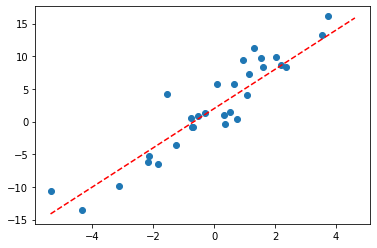

In [109]:
plt.scatter(x, y)
plt.plot(np.arange(x.min(),x.max() + 1), a_gt*np.arange(x.min(),x.max()+1) + b_gt, '--r')

In [110]:
def loss_ls(w, X, y):
    return (((X@w)-y).T @ ((X@w)-y))[0,0]

grad_ls = jax.grad(loss_ls)

In [111]:
X = jnp.concatenate([x[:, jnp.newaxis], jnp.ones((x.shape[0], 1))], axis=-1)
Y = y[:, jnp.newaxis]

In [112]:
grid_n = 40
min_x = -10
max_x = 10
min_y = -10
max_y = 10
margin = 0.2
w_X_grid, w_Y_grid = np.meshgrid(np.linspace(min_x-margin, max_x+margin, grid_n), np.linspace(min_y-margin, max_y+margin, grid_n))

In [113]:
w_Z_grid = np.zeros((grid_n, grid_n))
w_X_grad = np.zeros((grid_n, grid_n))
w_Y_grad = np.zeros((grid_n, grid_n))

for i in range(grid_n):
    for j in range(grid_n):
        w_i_j = np.array([[w_X_grid[i,j]],[w_Y_grid[i,j]]])
        w_Z_grid[i,j] = loss_ls(w_i_j, X=X, y=Y)
        grad_w_i_j = grad_ls(w_i_j, X=X, y=Y)
        w_X_grad[i,j] = grad_w_i_j[0]
        w_Y_grad[i,j] = grad_w_i_j[1]

prune_factor = 2
pruned_w_X_grad = w_X_grad[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_w_Y_grad = w_Y_grad[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_w_X_grid = w_X_grid[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_w_Y_grid = w_Y_grid[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]

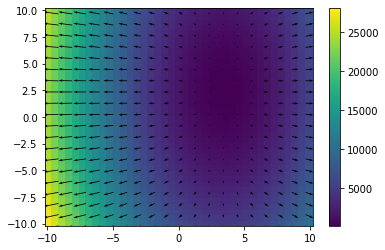

In [115]:
plt.pcolormesh(w_X_grid, w_Y_grid, w_Z_grid)
plt.colorbar()
plt.quiver(pruned_w_X_grid, pruned_w_Y_grid, pruned_w_X_grad, pruned_w_Y_grad, units='width')

In [116]:
def gradient_descent(grad_fn, loss_fn, alphas, init):
    xs = [init]
    losses = []
    x = init
    for alpha in alphas:
        loss = loss_fn(x)
        x = x - alpha * grad_fn(x)
        xs.append(x)
        losses.append(loss)
    return xs, losses

In [129]:
def meta_loss(alpha, loss_fn, grad_fn, init, steps=20):
    x = init
    loss_tot = jnp.array(0.)
    for step in range(steps):
        x = x - alpha * grad_fn(x)
        loss_tot += loss_fn(x)
    return loss_tot / steps

meta_alpha = jnp.array(0.0000000001)
init_alpha = jnp.array(0.000000001)
meta_grad = jax.grad(meta_loss)
w_0 = 3*jnp.array(np.random.randn(2, 1))

xs, losses = gradient_descent(grad_fn=partial(meta_grad,
                                              loss_fn=partial(loss_ls, X=X, y=Y),
                                              grad_fn=partial(grad_ls, X=X, y=Y),
                                              init=w_0),
                              loss_fn=partial(meta_loss,
                                              loss_fn=partial(loss_ls, X=X, y=Y),
                                              grad_fn=partial(grad_ls, X=X, y=Y),
                                              init=w_0),
                              alphas=[meta_alpha]*20,
                              init=init_alpha)

In [130]:
losses

[DeviceArray(4255.7188, dtype=float32),
 DeviceArray(295.60437, dtype=float32),
 DeviceArray(294.70523, dtype=float32),
 DeviceArray(293.82462, dtype=float32),
 DeviceArray(292.962, dtype=float32),
 DeviceArray(292.11676, dtype=float32),
 DeviceArray(291.28824, dtype=float32),
 DeviceArray(290.47607, dtype=float32),
 DeviceArray(289.67966, dtype=float32),
 DeviceArray(288.8986, dtype=float32),
 DeviceArray(288.1324, dtype=float32),
 DeviceArray(287.3805, dtype=float32),
 DeviceArray(286.64267, dtype=float32),
 DeviceArray(285.91837, dtype=float32),
 DeviceArray(285.2072, dtype=float32),
 DeviceArray(284.50894, dtype=float32),
 DeviceArray(283.823, dtype=float32),
 DeviceArray(283.14923, dtype=float32),
 DeviceArray(282.48718, dtype=float32),
 DeviceArray(281.83664, dtype=float32)]

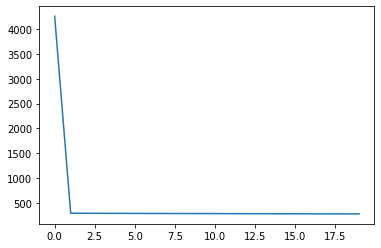

In [131]:
plt.plot(losses)

In [132]:
best_alpha = xs[-1]

In [133]:
print(best_alpha)

0.002254763


In [134]:
xs_best, losses_best = gradient_descent(loss_fn=partial(loss_ls, X=X, y=Y),
                              grad_fn=partial(grad_ls, X=X, y=Y),
                              init=w_0,
                              alphas=[best_alpha]*20)

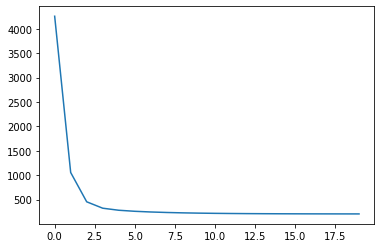

In [135]:
plt.plot(losses_best)

In [136]:
xs_best

[DeviceArray([[-2.210762 ],
              [-0.3518922]], dtype=float32), DeviceArray([[0.9493127 ],
              [0.00773877]], dtype=float32), DeviceArray([[2.2798285 ],
              [0.32576403]], dtype=float32), DeviceArray([[2.8403993],
              [0.6037322]], dtype=float32), DeviceArray([[3.0768993],
              [0.8453454]], dtype=float32), DeviceArray([[3.1769538],
              [1.0547991]], dtype=float32), DeviceArray([[3.2195225],
              [1.2361399]], dtype=float32), DeviceArray([[3.2378392],
              [1.3930428]], dtype=float32), DeviceArray([[3.2458963],
              [1.5287597]], dtype=float32), DeviceArray([[3.2495894],
              [1.646134 ]], dtype=float32), DeviceArray([[3.2514052],
              [1.7476375]], dtype=float32), DeviceArray([[3.2523956],
              [1.8354131]], dtype=float32), DeviceArray([[3.2530081],
              [1.9113162]], dtype=float32), DeviceArray([[3.2534351],
              [1.976952 ]], dtype=float32), DeviceArray([

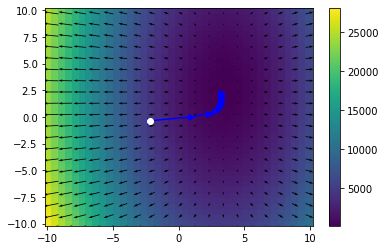

In [138]:
trajectory = np.concatenate(xs_best, axis=-1).T

plt.figure()
plt.pcolormesh(w_X_grid, w_Y_grid, w_Z_grid)
plt.colorbar()
plt.quiver(pruned_w_X_grid, pruned_w_Y_grid, pruned_w_X_grad, pruned_w_Y_grad, units='width')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b>-')
plt.plot(trajectory[0:1, 0], trajectory[0:1, 1], 'wo-')